In [83]:
import pandas as pd
import json
import numpy as np
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
import geopandas as gpd
import pysal as ps
import folium
from shapely.geometry import Point

from folium.plugins import HeatMap
# from pysal.contrib.viz import mapping as maps

In [84]:
# with open('data/drivers.json') as train_file:
#     dict_train = json.load(train_file)
# temp = pd.io.json.json_normalize(dict_train)
# # location.__type only has NAN and GeoPoint and NAN doesn't mean no location
# temp
# temp = temp.drop(columns=['id', 'location.__type', 'location'])
# temp.to_csv('data/driver.csv')
# # drop over 6 tags

In [85]:
# data cleanup
data = pd.read_csv('data/driver.csv', low_memory=False)
data.rename(index=str, columns={"location.latitude": "latitude", "location.longitude": "longitude"}, inplace=True)
data
# see data with no latitude or longtitude
print("Latitude, Longtitude is null:")
print(data['latitude'].isnull().sum())
print(data['longitude'].isnull().sum())
data = data[np.isfinite(data['latitude'])]
print("Latitude, Longtitude is null:")
print(data['latitude'].isnull().sum())
print(data['longitude'].isnull().sum())
data

Latitude, Longtitude is null:
28616
28616
Latitude, Longtitude is null:
0
0


createdAt                 dateTaken       licensePlate  \
1       2015-09-12T10:57:10.258Z                       NaN            A6888BP   
3       2016-09-22T10:19:16.497Z  2016-09-22T10:17:00.000Z           CT9441AK   
4       2016-04-30T19:59:15.623Z                       NaN           CA1695MC   
5       2016-09-04T17:57:16.637Z  2016-09-04T17:55:00.000Z            E3000AB   
6       2016-12-07T10:50:49.954Z  2016-12-07T10:48:00.000Z           CB6467AP   
7       2015-07-24T12:46:34.623Z                       NaN            A9292KM   
8       2015-06-24T08:14:20.986Z                       NaN           CA7848TB   
10      2016-12-22T12:56:12.515Z  2016-12-22T12:55:00.000Z           CA7388TX   
12      2015-08-25T08:55:21.257Z                       NaN            X8273BP   
13      2015-10-25T20:50:25.278Z                       NaN           CA5143HM   
15      2016-06-30T15:55:07.101Z  2016-06-30T15:52:00.000Z           CB8929BA   
16      2016-03-18T11:24:45.159Z                       NaN           CB9509AX   
17      2016-03-02T17:27:19.586Z                       NaN           CA5855MX   
18      2015-03-15T11:25:43.239Z                       NaN            B1723PC   
22      2015-12-21T10:53:06.597Z                       NaN           PB5943PX   
23      2016-12-29T07:54:25.151Z  2016-12-29T07:51:00.000Z           CB9054AK   
26      2016-04-23T09:09:00.041Z                       NaN           CO0848BH   
27      2016-03-28T18:51:01.442Z                       NaN           CA7385PB   
29      2015-06-19T20:23:16.033Z                       NaN            B1010HK   
30      2015-04-12T21:36:45.247Z                       NaN            B3987AT   
31      2016-05-16T12:30:47.663Z                       NaN           CA0895XC   
32      2015-12-14T09:49:50.115Z                       NaN           CA8757TC   
34      2017-05-17T12:19:04.359Z  2017-05-17T12:16:00.000Z           CA2948MB   
38      2015-11-26T17:13:30.939Z                       NaN           CA1668XP   
40      2015-05-24T11:14:17.097Z                       NaN           CA7454TH   
42      2015-04-02T17:02:17.037Z                       NaN           PB1681MX   
43      2015-09-03T13:09:32.376Z                       NaN           CB2315AM   
44      2016-04-06T11:45:10.419Z                       NaN           CA7522MA   
45      2015-08-20T09:15:36.415Z                       NaN           BH5136BM   
46      2015-03-19T07:53:23.277Z                       NaN           CA2399XA   
48      2016-07-01T19:57:18.902Z  2016-06-28T17:37:00.000Z           CB4711BB   
50      2016-03-18T06:45:34.967Z                       NaN            P8323AT   
51      2016-04-01T12:12:34.678Z                       NaN           CA7492CX   
52      2015-03-15T15:21:56.659Z                       NaN           CA1401CT   
53      2015-03-22T12:21:50.632Z                       NaN            B5333BA   
54      2016-08-27T08:55:35.089Z  2016-08-27T08:49:00.000Z           CO4273BP   
55      2017-04-07T04:45:25.896Z  2017-04-06T15:44:00.000Z           CA8469TT   
56      2017-03-10T16:17:12.012Z  2017-03-10T16:15:00.000Z           CA8255XT   
57      2015-05-22T12:13:55.241Z                       NaN            A8880MP   
61      2015-03-31T12:25:29.275Z                       NaN           CB8659AB   
63      2016-10-03T19:38:53.948Z  2016-10-02T07:30:00.000Z           PB3762PC   
64      2015-05-18T13:23:05.329Z                       NaN           CA0293CT   
66      2016-05-09T21:35:57.944Z                       NaN            C8787HK   
68      2015-10-25T11:32:04.838Z                       NaN            B2397KC   
71      2017-02-07T14:23:38.458Z  2017-02-07T13:31:00.000Z           CA3521XC   
72      2015-09-05T19:55:11.703Z                       NaN           PB9192AM   
73      2015-03-28T16:32:25.552Z                       NaN            K5963BB   
74      2015-04-17T06:50:21.651Z                       NaN            B1511PK   
76      2015-04-30T15:38:58.405Z                      

In [86]:
#convert createdAt and dateTaken to datetime format
data.createdAt = pd.to_datetime(data.createdAt)

# impute dateTaken to be similar to createdAt when is nan
# a different aproach is to subtract the mean between createdAt and dateTaken
data.dateTaken = data.apply(
    lambda row: row['createdAt'] if pd.isnull(row['dateTaken']) else row['dateTaken'], axis=1)

data.dateTaken = pd.to_datetime(data.dateTaken)

In [87]:
# select illegal parking problems
data.selectedTags1.unique()
# remove quotes and smiles in the Tags
# ...
# strip selectedTags
selected_tags_list = []
for i in range(1,7):
    selected_tags_list.append('selectedTags' + str(i))
    data['selectedTags' + str(i)] = data['selectedTags' + str(i)].str.strip()

driver_tags = list(set(data.selectedTags1.unique()) | set(data.selectedTags2.unique()) | set(data.selectedTags3.unique()) | 
     set(data.selectedTags4.unique()) | set(data.selectedTags5.unique()) | set(data.selectedTags6.unique()))
driver_tags

parking_rename_map = {"Паркиране/Спиране на пешеходна пътека": "Паркиране пешеходна",
                    "Паркиране на кръстовище": "Паркиране кръстовище",
                    "Неправилно паркиране": "Паркиране неправилно",
                    "Паркиране на автобусна спирка": "Паркиране спирка",
                    "Паркиране на тротоар": "Паркиране тротоар",
                    "Блокиране на вход": "Паркиране вход",
                    "Паркиране/движение по велоалея след знак Г14/16": "Паркиране велоалея",
                    "Паркиране на инвалидно място": "Паркиране инвалидно",
                    "Паркиране на таксиметрова стоянка": "Паркиране стоянка",
                    "Нарушение след знак В27 или В28 (Паркиране или престой)": "Паркиране знакБ",
                    "Паркиране/Шофиране в парк": "Паркиране парк",
                    "Паркиране whatever...": "Паркиране нагло",
                    "Паркиране на зелени площи": "Паркиране зелени"
                     }

for tag in selected_tags_list:
    data[tag] = data[tag].map(parking_rename_map)

In [88]:
# filter illegal parking problems in parking_data
parking_data_mask = data[selected_tags_list].stack(dropna=False).str.contains('Паркиране').unstack().any(axis='columns')
parking_data = data[parking_data_mask].copy()
# parking_data[selected_tags_list].stack().value_counts()

# add illegal parking column to data
data['illegal_parking'] = parking_data_mask

In [89]:
for value in parking_rename_map.values():
    data[value] = data[selected_tags_list].stack(dropna=False).str.contains(value).unstack().any(axis='columns')
    parking_data[value] = parking_data[selected_tags_list].stack(dropna=False).str.contains(value).unstack().any(axis='columns')

In [90]:
# drop not needed columns
pd.options.display.max_columns = 32
parking_data.drop(columns=selected_tags_list, inplace=True)
parking_data.drop(columns=['pictures'], inplace=True)

In [91]:
pd.options.display.max_rows = 512
parking_data.licensePlate.replace('\d+\w+.+$', '', regex=True, inplace=True)

# replace misstyped registration numbers
license_plate_map = {'SA': 'CA', 
                    'SV': 'CB', 
                    'XX': 'XX', 
                    'V': 'B', 
                    'ST': 'CT', 
                    'R': 'P', 
                    'EN': 'EH', 
                    'SM': 'CM', 
                    'TH': 'TX', 
                    'RV': 'PB', 
                    'СA': 'CA', 
                    'СB': 'CB', 
                    'AA': 'AA', 
                    'CV': 'CB', 
                    'С': 'C', 
                    'SS': 'CC', 
                    'S': 'C', 
                    'SN': 'CH', 
                    'VT': 'BT', 
                    'KN': 'KH', 
                    'VR': 'BP', 
                    'W': 'B', 
                    'SO': 'CO', 
                    'SB': 'CB', 
                    'EV': 'EB', 
                    'ВP': 'BP', 
                    'ОB': 'OB', 
                    'H': 'H', 
                    'A': 'A', 
                    'ТX': 'TX', 
                    'PV': 'PB', 
                    'CБ': 'CB', 
                    'SW': 'CB'
}

parking_data.licensePlate.replace(license_plate_map.keys(), license_plate_map.values(), inplace=True)
licence_plate_counts = parking_data.licensePlate.value_counts()

# remove rows that contain wrong license plate numbers and no license plate numbers
parking_data = parking_data[parking_data.isin(licence_plate_counts.index[licence_plate_counts >= 16]).values]
# remove rows with empty strings for license plates


filter = parking_data['licensePlate'] != ""
parking_data = parking_data[filter]

# parking_data.licensePlate = parking_data.licensePlate.replace('', np.nan, inplace=True)
# parking_data = parking_data.dropna(subset=['licensePlate'], inplace=True)


# parking_data = parking_data[parking_data.isin(licence_plate_counts.index[licence_plate_counts == 146]).values]

C, CB, CA: 33927 ; as fraction: 0.6546833391223804
Rest of BG: 17895 ; as fraction: 0.34531666087761953


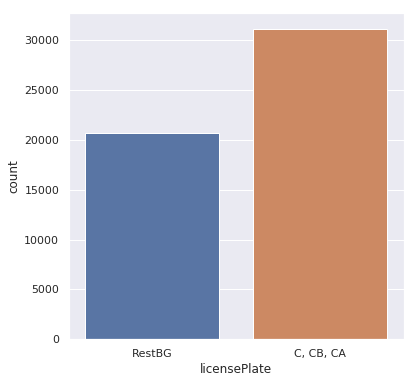

In [92]:
# Sofia vs the world
sofia_plates = parking_data.licensePlate.str.contains('CB|CA|C').sum()
non_sofia_plates = parking_data.shape[0] - sofia_plates
print("C, CB, CA:", sofia_plates, "; as fraction:", sofia_plates/(sofia_plates + non_sofia_plates))
print("Rest of BG:", non_sofia_plates, "; as fraction:", non_sofia_plates/(sofia_plates + non_sofia_plates))

sofia_vs_rest = parking_data.licensePlate.map({'CB': 'C, CB, CA', 'CA': 'C, CB, CA', 'C': 'C, CB, CA'}).fillna('RestBG')
sns.set(style="darkgrid", rc={'figure.figsize':(6,6)})
ax = sns.countplot(sofia_vs_rest)

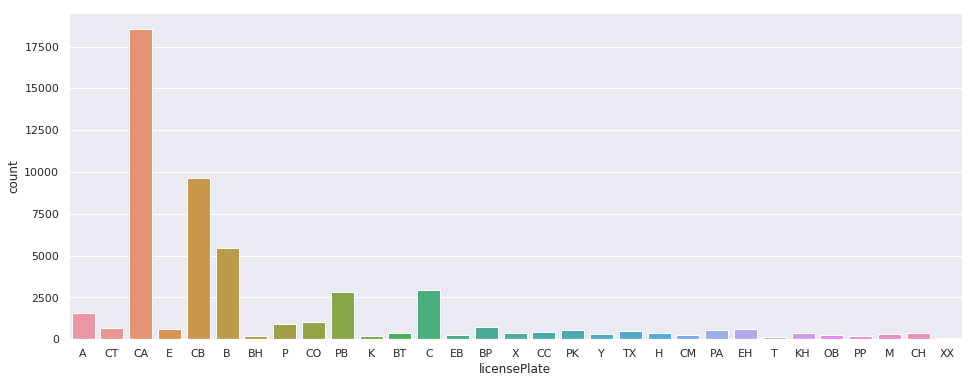

In [93]:
# who's the baddest?
sns.set(style="darkgrid", rc={'figure.figsize':(16,6)})
ax = sns.countplot(x="licensePlate", data=parking_data)

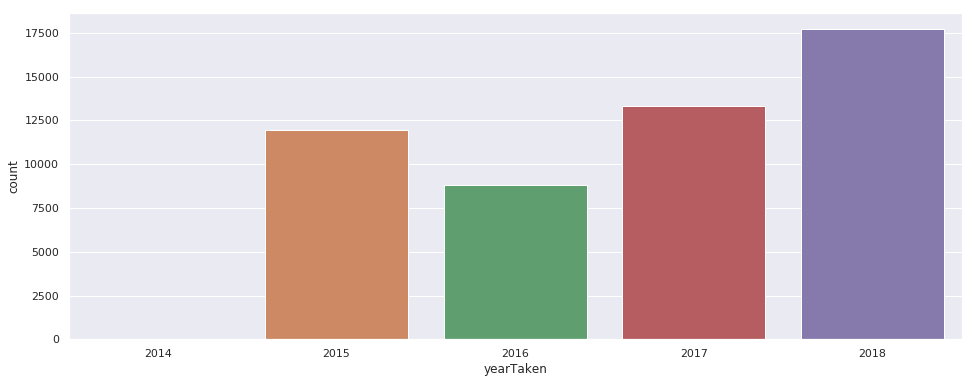

In [94]:
# данни по години, месеци, дни от седмицата
parking_data['yearTaken'] = parking_data['dateTaken'].dt.year
parking_data['monthTaken'] = parking_data['dateTaken'].dt.month
parking_data['weekdayTaken'] = parking_data['dateTaken'].dt.day_name()
parking_data['hourTaken'] = parking_data['dateTaken'].dt.hour

# yearly, monthly, weekday reports
sns.set(style="darkgrid", rc={'figure.figsize':(16,6)})
ax = sns.countplot(x="yearTaken", data=parking_data)

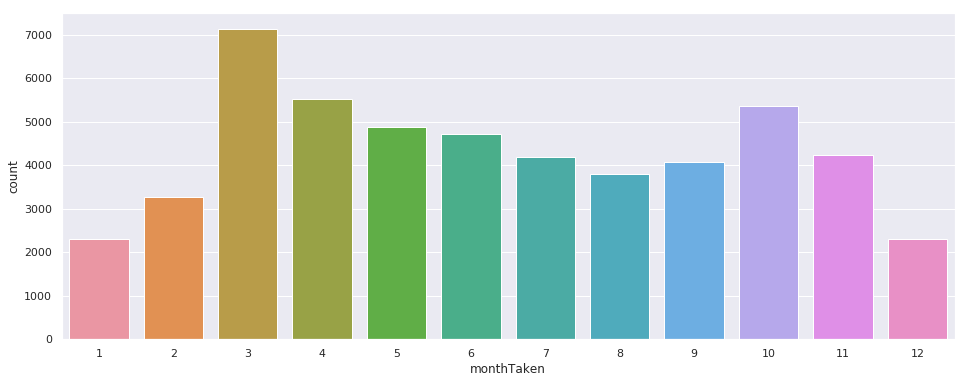

In [95]:
sns.set(style="darkgrid", rc={'figure.figsize':(16,6)})
ax = sns.countplot(x="monthTaken", data=parking_data)

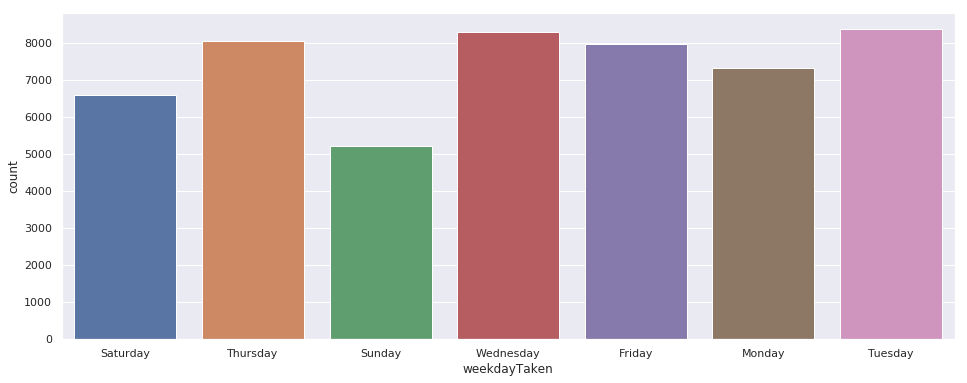

In [96]:
sns.set(style="darkgrid", rc={'figure.figsize':(16,6)})
ax = sns.countplot(x="weekdayTaken", data=parking_data)

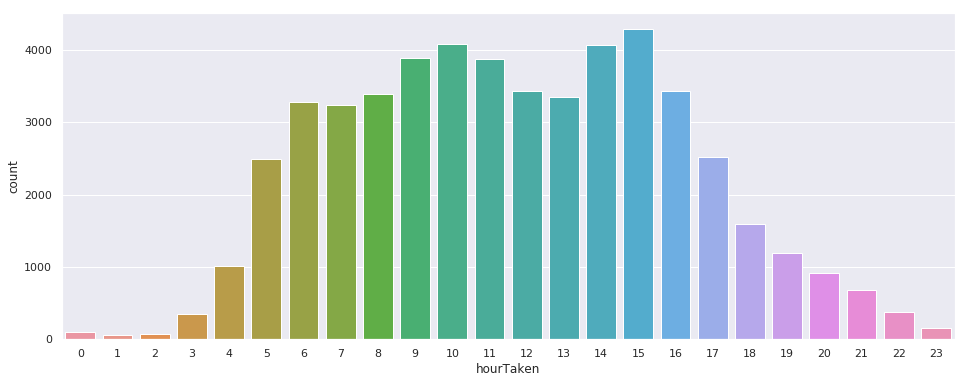

In [97]:
# probably UTC?
sns.set(style="darkgrid", rc={'figure.figsize':(16,6)})
ax = sns.countplot(x="hourTaken", data=parking_data)

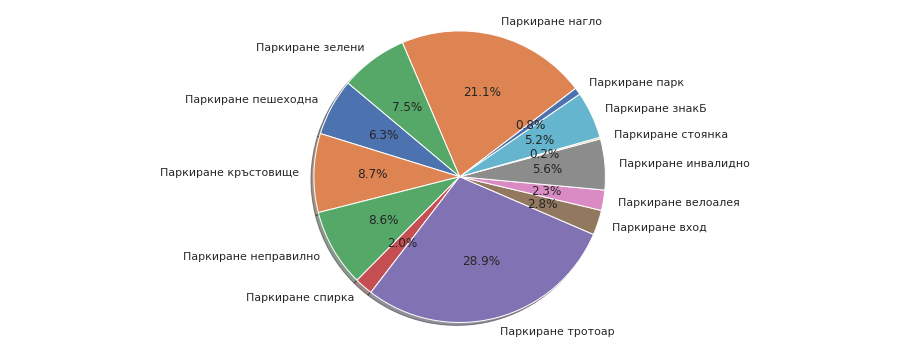

In [98]:
labels = tuple(parking_rename_map.values())
sizes = []

[sizes.append(parking_data[val].sum()) for val in parking_rename_map.values()]

# print(labels)
# print(sizes)

# explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  # explode 1st slice
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.axis('equal')
plt.show()

In [154]:
lsoas_link = 'data/nas_kv_wgs84/Naselenie_kvartali_wgs84.shp'
lsoas = gpd.read_file(lsoas_link)
lsoas.drop(columns=['NSettlemen', 'Broi_Lica', 'Broi_Jil', 'Male', 'Female', 'Age0_14', 'Age15_24', 'Age25_34',
                    'Age35_44', 'Age45_54', 'Age55_64', 'AgeOver65', 'Educ1', 'Educ2', 'Educ3', 'Educ4', 'Educ5'],
          inplace=True)

In [209]:
reg_counts = all.Rajon.value_counts()
print("Rajon counts:\n", reg_counts)


reg_counts = all.RegName.value_counts()
print("\nRegName counts:\n", reg_counts)

Rajon counts:
 Триадица                       3507
Лозенец                        3396
Младост                        2945
Красно село                    2655
Възраждане                     2611
Средец                         2607
Изгрев                         2240
Слатина                        2180
Студентска                     1664
Оборище                        1526
Витоша                         1516
Подуене                        1191
Люлин                          1088
Овча Купел                      900
Лозенец / Триадица              731
Искър                           673
Илинден                         610
Надежда                         581
Красна поляна                   568
Сердика                         394
Надежда / Връбница              259
Връбница                        238
Възраждане / Триадица           225
Сердика / Илинден               222
Средец / Оборище                144
Банкя                           121
Панчарево                       111
Кремиковци   

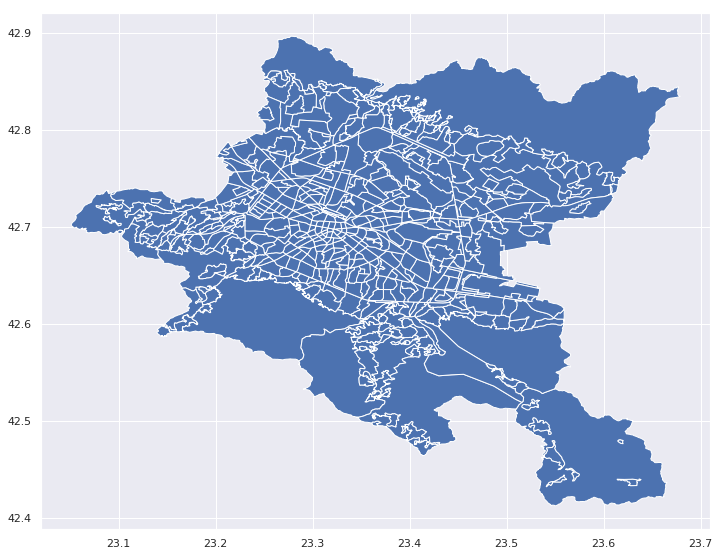

In [155]:
ls = lsoas.plot()

In [104]:
parking_data.longitude
parking_data['geometry'] = list(zip(parking_data.longitude, parking_data.latitude))
parking_data['geometry'] = parking_data['geometry'].apply(Point)
parking_data = geopandas.GeoDataFrame(parking_data, geometry='geometry')

createdAt               dateTaken licensePlate  \
1      2015-09-12 10:57:10.258 2015-09-12 10:57:10.258            A   
622    2015-09-12 10:42:55.705 2015-09-12 10:42:55.705           CA   
731    2016-03-15 11:57:01.552 2016-03-15 11:57:01.552           CA   
1049   2015-10-10 14:27:27.870 2015-10-10 14:27:27.870           CA   
2048   2015-03-01 13:15:43.690 2015-03-01 13:15:43.690           CA   
2567   2015-12-29 16:06:09.456 2015-12-29 16:06:09.456           CA   
3527   2015-04-20 13:27:57.009 2015-04-20 13:27:57.009            C   
3548   2017-02-21 15:40:23.096 2017-02-21 09:14:00.000           CA   
4497   2017-02-18 13:13:57.822 2017-02-18 12:27:00.000           CA   
4722   2017-04-21 18:12:40.428 2017-04-21 18:10:00.000           PK   
5041   2016-01-31 10:05:08.288 2016-01-31 10:05:08.288            C   
6821   2015-05-11 13:04:07.144 2015-05-11 13:04:07.144            C   
6913   2015-04-14 14:40:09.660 2015-04-14 14:40:09.660           CA   
7265   2015-02-27 10:26:47.162 2015-02-27 10:26:47.162           CA   
7479   2017-02-01 19:32:16.598 2017-02-01 17:44:00.000           CA   
7762   2015-07-01 18:29:43.733 2015-07-01 18:29:43.733           KH   
8074   2015-10-10 14:35:05.857 2015-10-10 14:35:05.857           CA   
8164   2015-10-14 14:37:31.059 2015-10-14 14:37:31.059           CB   
8349   2015-06-19 16:42:19.766 2015-06-19 16:42:19.766           CA   
8458   2015-03-01 12:33:48.604 2015-03-01 12:33:48.604            C   
8586   2016-09-17 09:50:47.798 2016-09-17 09:48:00.000           BT   
8809   2015-04-22 13:41:00.294 2015-04-22 13:41:00.294           CA   
11328  2015-05-11 13:02:40.726 2015-05-11 13:02:40.726            C   
11885  2016-02-07 19:43:06.805 2016-02-07 19:43:06.805           CA   
12159  2015-09-25 09:59:53.975 2015-09-25 09:59:53.975           CA   
12923  2017-04-29 15:33:20.913 2017-04-29 15:28:00.000           CA   
13809  2015-06-26 16:06:22.549 2015-06-26 16:06:22.549           CA   
14112  2015-05-11 12:57:14.607 2015-05-11 12:57:14.607           CA   
14648  2016-08-21 15:59:35.555 2016-08-21 15:58:00.000           CA   
16227  2015-09-12 10:51:47.934 2015-09-12 10:51:47.934            A   
17068  2017-02-21 15:35:16.913 2017-02-21 08:33:00.000           CA   
17676  2015-03-03 09:47:46.698 2015-03-03 09:47:46.698           CA   
19666  2016-04-22 16:44:09.320 2016-04-22 16:44:09.320            C   
19703  2016-09-19 04:49:23.526 2016-09-19 04:47:00.000           CA   
20486  2015-03-01 13:18:13.974 2015-03-01 13:18:13.974           CA   
21615  2016-11-20 12:17:36.680 2016-11-20 12:17:00.000           CA   
21830  2015-04-10 17:23:37.781 2015-04-10 17:23:37.781           CA   
22266  2015-03-01 12:41:01.332 2015-03-01 12:41:01.332            C   
22389  2017-02-23 09:48:24.295 2017-02-23 09:45:00.000           CA   
22577  2015-03-29 12:00:41.503 2015-03-29 12:00:41.503           CA   
22812  2016-08-21 15:45:03.111 2016-08-21 15:43:00.000           CB   
22888  2017-03-08 16:49:42.262 2017-03-08 16:46:00.000           CB   
23215  2017-01-26 06:33:21.892 2017-01-26 06:18:00.000           CB   
26495  2015-12-17 11:14:41.220 2015-12-17 11:14:41.220           CA   
27058  2016-05-07 09:59:51.915 2016-05-07 09:59:51.915           CA   
28070  2015-06-26 16:07:51.192 2015-06-26 16:07:51.192           CA   
28370  2015-03-03 10:10:20.322 2015-03-03 10:10:20.322           CA   
29506  2015-09-04 06:59:27.013 2015-09-04 06:59:27.013           CA   
29641  2015-02-27 09:52:50.898 2015-02-27 09:52:50.898           CA   
30133  2015-04-25 14:58:10.155 2015-04-25 14:58:10.155           CB   
32821  2015-10-04 08:11:38.924 2015-10-04 08:11:38.924           CA   
32916  2015-03-17 13:21:37.328 2015-03-17 13:21:37.328           CB   
33734  2017-05-15 19:20:34.457 2017-05-03 15:55:00.000           CA   
33798  2015-10-05 05:47:31.754 2015-10-05 05:47:31.754           CA   
34685  2015-02-27 10:30:00.314 2015-02-27 10:30:00.314           CA   
36130  2015-09-12 10:54:50.142 2015-09-12 10:

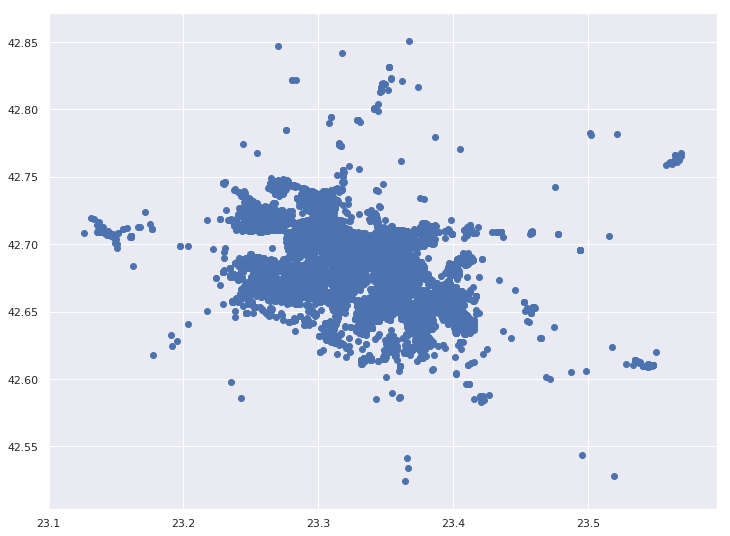

In [211]:
all = geopandas.sjoin(parking_data, lsoas, how="inner", op='within')
allplot = all.plot()

In [217]:
# all['illegal_parking'] = all.apply(lambda state: parking_data.within(all.geometry).sum(), axis=1)
test_dict = dict(all.RegName.value_counts())
lsoas['illegal_parking'] = lsoas['RegName'].map(test_dict)
# df["B"] = df["A"].map(equiv)

# states['wafflehouse_count'] = states.apply(lambda state: wafflehouses.within(state.geometry).sum(), axis=1)

RegName  \
index_right                                                      
0                           Зона за отдих Шишмановски манастир   
1                                           в.з. Татарски брод   
2                                   Панчарево, в.з.Лавандулите   
3                                            Манастир Св. Илия   
4                             Панчарево, в.з. Щъркелово гнездо   
5                   Хидропарк Искър - Вододайна зона яз. Искър   
6                                                   м. Пасарел   
7                                                     с. Плана   
8                       с. Железница, в.з. Звездана (Църквище)   
9                          с. Железница, в.з. Елата - Кошарите   
10                                             м. Язовир Искър   
11           с. Железница - махала Чемерник" и "Цареви кошари"   
12                                 с.Долни Пасарел, в.з. Расул   
13                                           с.  Долни Пасарел   
14                                            Лозенска планина   
15                                                с. Железница   
16                                          в.з. Долни Пасарел   
17                                                 с. Кокаляне   
18                                       в.з. Кокаляне - Бачол   
19                                               в.з. Кокаляне   
20                          с. Бистрица, ж.г. Планински гледки   
21                                    Панчарево, в.з. Църнокос   
22                              в.з. Бистрица - Цонкина махала   
23                                                 с. Бистрица   
24                                   с.Бистрица, м. Орешковица   
25                                     Панчарево, в.з Беликата   
26                                                с. Панчарево   
27                                   с. Бистрица, м. Чипровица   
28                                     м. Долни Лозен - м. БЧК   
29                                   в.з.Бистрица - Калфин дол   
30                                                в.з. Градище   
31                                              с. Долни Лозен   
32                                  с. Мърчаево, м.Манастирище   
33                             Зона за отдих Панчарево - плажа   
34                                                    с. Лозен   
35                                        Бистрица - резервата   
36                                    м.  Чоланица - Четарлъка   
37                                    в.з. Бистрица - Шираната   
38                                   с. Г. Лозен, в.з. Чаушица   
39                            с. Лозен, м. Бърдо - Св. Димитър   
40                                      с.Герман, в.з.Терасите   
41                                           Герман, м. Шамака   
42                                             в.з.Косанин дол   
43                                                 с. Мърчаево   
44                                   с. Лозен, м. Орлова круша   
45                                                   с. Герман   
46                                         ж.г. София - вилидж   
47                               хидропарк Искър - част Герман   
48                          Панчарево - Черешови градини изток   
49                                   с. Г. Лозенм. Ефенди мост   
50                                с. Панчарево, м. Детски град   
51                                            м. Сръбски азмак   
52                                              Парк Камбаните   
53                               в.з. Малинова Долина - герена   
54                                в.з. Малинова долина - изток   
55                                  с. Герман, м. Старият мост   
56                                         с. Владая, м.Габера   
57                               в.з. Малинова доолина - запад   
58                                  с. Д. Лозен, м. Крива река   
59                           

{'ж.к. Изток - изток': 1369,
 'м. Лозенец част 2 и 3 - юг': 893,
 'ж.к. Гео Милев': 874,
 'ЦГЧ Зона Г12': 780,
 'ж.к. Младост 4': 736,
 'м.Лозенец част 1': 731,
 'м. Лозенец част 3': 730,
 'ж.к. Младост 1': 704,
 'НПЗ Хладилника': 677,
 'ж.к. Дианабад': 670,
 'кв. Подуяне': 663,
 'ж.к. Гоце Делчев': 642,
 'м. Подуяне-Център': 572,
 'ж.к. Хиподрума': 566,
 'ЦГЧ Зони Г10 и част от А': 556,
 'ж.к. Стрелбище': 548,
 'ЦГЧ Зона Г6': 535,
 'кв. Хладилника': 520,
 'ЦГЧ Зона Г8': 518,
 'ЦГЧ Зона Б5+': 512,
 'ж.к. Студентски град - запад': 496,
 'ж.к. Младост 3': 444,
 'ж.к. Суха река - запад': 443,
 'ж.к. Дървеница': 443,
 'кв. Крива река': 441,
 'ж.к. Иван Вазов': 438,
 'ж.к. Гевгелийски, ж.к. Илинден': 438,
 'НПЗ Средец': 425,
 'ЦГЧ Зона Б4+': 423,
 'м. Манастирски ливади - запад': 388,
 'ж.к. Овча Купел': 387,
 '3-та извънградска част': 384,
 'ЦГЧ Зона Г8-Средец': 381,
 'ж.к. Младост 2': 352,
 'ЦГЧ Зона Б19+': 346,
 'ж.к. Надежда 2': 342,
 'кв. Павлово-Бъкстон': 340,
 'ж.к. Борово': 324,
 'ж

In [194]:
print(dict(all.Rajon.value_counts()).keys())
dict(all.Rajon.value_counts()).values()

dict_keys(['Триадица', 'Лозенец', 'Младост', 'Красно село', 'Възраждане', 'Средец', 'Изгрев', 'Слатина', 'Студентска', 'Оборище', 'Витоша', 'Подуене', 'Люлин', 'Овча Купел', 'Лозенец / Триадица', 'Искър', 'Илинден', 'Надежда', 'Красна поляна', 'Сердика', 'Надежда / Връбница', 'Връбница', 'Възраждане / Триадица', 'Сердика / Илинден', 'Средец / Оборище', 'Банкя', 'Панчарево', 'Кремиковци', 'Нови Искър', 'Младост / Студентска', 'Витоша / Панчарево', 'Подуене / Кремиковци', 'Красна поляна  / Овча Купел', 'Нови Искър / Кремиковци', 'Сердика / Илинден / Надежда', 'Искър / Панчарево', 'Красна поляна / Овча Купел', 'Подуене / Слатина', 'Сердика / Надежда'])


dict_values([3507, 3396, 2945, 2655, 2611, 2607, 2240, 2180, 1664, 1526, 1516, 1191, 1088, 900, 731, 673, 610, 581, 568, 394, 259, 238, 225, 222, 144, 121, 111, 54, 46, 44, 28, 22, 21, 11, 4, 4, 3, 2, 1])

In [195]:
lsoas

RegName  \
index_right                                                      
0                           Зона за отдих Шишмановски манастир   
1                                           в.з. Татарски брод   
2                                   Панчарево, в.з.Лавандулите   
3                                            Манастир Св. Илия   
4                             Панчарево, в.з. Щъркелово гнездо   
5                   Хидропарк Искър - Вододайна зона яз. Искър   
6                                                   м. Пасарел   
7                                                     с. Плана   
8                       с. Железница, в.з. Звездана (Църквище)   
9                          с. Железница, в.з. Елата - Кошарите   
10                                             м. Язовир Искър   
11           с. Железница - махала Чемерник" и "Цареви кошари"   
12                                 с.Долни Пасарел, в.з. Расул   
13                                           с.  Долни Пасарел   
14                                            Лозенска планина   
15                                                с. Железница   
16                                          в.з. Долни Пасарел   
17                                                 с. Кокаляне   
18                                       в.з. Кокаляне - Бачол   
19                                               в.з. Кокаляне   
20                          с. Бистрица, ж.г. Планински гледки   
21                                    Панчарево, в.з. Църнокос   
22                              в.з. Бистрица - Цонкина махала   
23                                                 с. Бистрица   
24                                   с.Бистрица, м. Орешковица   
25                                     Панчарево, в.з Беликата   
26                                                с. Панчарево   
27                                   с. Бистрица, м. Чипровица   
28                                     м. Долни Лозен - м. БЧК   
29                                   в.з.Бистрица - Калфин дол   
30                                                в.з. Градище   
31                                              с. Долни Лозен   
32                                  с. Мърчаево, м.Манастирище   
33                             Зона за отдих Панчарево - плажа   
34                                                    с. Лозен   
35                                        Бистрица - резервата   
36                                    м.  Чоланица - Четарлъка   
37                                    в.з. Бистрица - Шираната   
38                                   с. Г. Лозен, в.з. Чаушица   
39                            с. Лозен, м. Бърдо - Св. Димитър   
40                                      с.Герман, в.з.Терасите   
41                                           Герман, м. Шамака   
42                                             в.з.Косанин дол   
43                                                 с. Мърчаево   
44                                   с. Лозен, м. Орлова круша   
45                                                   с. Герман   
46                                         ж.г. София - вилидж   
47                               хидропарк Искър - част Герман   
48                          Панчарево - Черешови градини изток   
49                                   с. Г. Лозенм. Ефенди мост   
50                                с. Панчарево, м. Детски град   
51                                            м. Сръбски азмак   
52                                              Парк Камбаните   
53                               в.з. Малинова Долина - герена   
54                                в.з. Малинова долина - изток   
55                                  с. Герман, м. Старият мост   
56                                         с. Владая, м.Габера   
57                               в.з. Малинова доолина - запад   
58                                  с. Д. Лозен, м. Крива река   
59                           

In [189]:

for val in reg_counts:
    lsoas['RegName'] == valt

Rajon counts:  Триадица                       3507
Лозенец                        3396
Младост                        2945
Красно село                    2655
Възраждане                     2611
Средец                         2607
Изгрев                         2240
Слатина                        2180
Студентска                     1664
Оборище                        1526
Витоша                         1516
Подуене                        1191
Люлин                          1088
Овча Купел                      900
Лозенец / Триадица              731
Искър                           673
Илинден                         610
Надежда                         581
Красна поляна                   568
Сердика                         394
Надежда / Връбница              259
Връбница                        238
Възраждане / Триадица           225
Сердика / Илинден               222
Средец / Оборище                144
Банкя                           121
Панчарево                       111
Кремиковци   

In [122]:
lsoas.iloc[0].geometry
parking_data.iloc[0].geometry.within(lsoas.iloc[0].geometry)

False

In [168]:
print(lsoas.crs)
parking_data.crs

{'init': 'epsg:32634'}


{'init': 'epsg:32634'}

In [169]:
for i in range(lsoas.shape[0]):
    for j in range(parking_data.shape[0]):
        print(parking_data.iloc[j].geometry)
        print(lsoas.iloc[i].geometry)
        if parking_data.iloc[j].geometry.within(lsoas.iloc[i].geometry):
            print("ga")

POINT (23.2683721 42.7135982)
POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.6

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

POINT (23.2602722 42.6730691)
POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.6

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

POINT (27.9070524 43.2179765)
POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.6

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

POINT (23.3453492303183 42.68572362518029)
POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.4334767

POINT (23.2939888 42.6909005)
POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.6

POINT (24.531396 43.4716355)
POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

POLYGON ((23.61444963639252 42.43907487722348, 23.61400253331841 42.43930699124301, 23.61392381834118 42.43983652089439, 23.61760181168862 42.43969894599209, 23.6210777095738 42.43960850917732, 23.62753741107647 42.4397557273865, 23.62980844117792 42.43991240787489, 23.6314903571108 42.43965700318952, 23.63389287105131 42.43927286079985, 23.63566139939792 42.43882874307829, 23.63650582830032 42.43927514357164, 23.6363941257932 42.43997256907891, 23.63651851705661 42.44011088033141, 23.63739198240359 42.4398017919053, 23.63855080625509 42.43945209163395, 23.6376423153779 42.43870976168457, 23.63704105998584 42.43830772085033, 23.63470028420811 42.43836521987436, 23.63427917587855 42.43762784247869, 23.63467290745306 42.43652296394995, 23.63457832498053 42.43650232428083, 23.63468347814253 42.43642523104577, 23.63429198367772 42.43321524464078, 23.63329915080669 42.43324908538433, 23.62782141285778 42.43306459111094, 23.62696901523484 42.43347675351644, 23.62602387486437 42.4333771789459

KeyboardInterrupt: 

In [164]:
lsoas.crs = parking_data.crs.copy()

In [ ]:
lsoas.crs

In [ ]:
for i in range(lsoas.shape[0]):
    for j in range(parking_data.shape[0]):
        #print(parking_data.iloc[j].geometry)
        #print(lsoas.iloc[i].geometry)
        if parking_data.iloc[j].geometry.within(lsoas.iloc[i].geometry):
            print("ga")

In [ ]:
# нови линии на градски транспорт (метро, нови линии, нови автобуси, нощните линии)
# има регистрационни номера, които са последователност от някоколко, обикновено разделени с ; e.g. data.iloc[27258]
# броят на нарушения на коли от София/провинцията преди/след зона
# leafLet
# ново разписание на зелена/синя зона

In [143]:
lsoas.crs

{'init': 'epsg:32634'}

In [147]:
parking_data.crs

{'init': 'epsg:32634'}

In [156]:
lsoas

RegName  \
0                   Зона за отдих Шишмановски манастир   
1                                   в.з. Татарски брод   
2                           Панчарево, в.з.Лавандулите   
3                                    Манастир Св. Илия   
4                     Панчарево, в.з. Щъркелово гнездо   
5           Хидропарк Искър - Вододайна зона яз. Искър   
6                                           м. Пасарел   
7                                             с. Плана   
8               с. Железница, в.з. Звездана (Църквище)   
9                  с. Железница, в.з. Елата - Кошарите   
10                                     м. Язовир Искър   
11   с. Железница - махала Чемерник" и "Цареви кошари"   
12                         с.Долни Пасарел, в.з. Расул   
13                                   с.  Долни Пасарел   
14                                    Лозенска планина   
15                                        с. Железница   
16                                  в.з. Долни Пасарел   
17                                         с. Кокаляне   
18                               в.з. Кокаляне - Бачол   
19                                       в.з. Кокаляне   
20                  с. Бистрица, ж.г. Планински гледки   
21                            Панчарево, в.з. Църнокос   
22                      в.з. Бистрица - Цонкина махала   
23                                         с. Бистрица   
24                           с.Бистрица, м. Орешковица   
25                             Панчарево, в.з Беликата   
26                                        с. Панчарево   
27                           с. Бистрица, м. Чипровица   
28                             м. Долни Лозен - м. БЧК   
29                           в.з.Бистрица - Калфин дол   
30                                        в.з. Градище   
31                                      с. Долни Лозен   
32                          с. Мърчаево, м.Манастирище   
33                     Зона за отдих Панчарево - плажа   
34                                            с. Лозен   
35                                Бистрица - резервата   
36                            м.  Чоланица - Четарлъка   
37                            в.з. Бистрица - Шираната   
38                           с. Г. Лозен, в.з. Чаушица   
39                    с. Лозен, м. Бърдо - Св. Димитър   
40                              с.Герман, в.з.Терасите   
41                                   Герман, м. Шамака   
42                                     в.з.Косанин дол   
43                                         с. Мърчаево   
44                           с. Лозен, м. Орлова круша   
45                                           с. Герман   
46                                 ж.г. София - вилидж   
47                       хидропарк Искър - част Герман   
48                  Панчарево - Черешови градини изток   
49                           с. Г. Лозенм. Ефенди мост   
50                        с. Панчарево, м. Детски град   
51                                    м. Сръбски азмак   
52                                      Парк Камбаните   
53                       в.з. Малинова Долина - герена   
54                        в.з. Малинова долина - изток   
55                          с. Герман, м. Старият мост   
56                                 с. Владая, м.Габера   
57                       в.з. Малинова доолина - запад   
58                          с. Д. Лозен, м. Крива река   
59                   м.Автомагистрала Тракия-м.Прогоно   
60                     с. Г. Лозен, м. Опитното поле -   
61                     с. Г. Лозен, м. Иванкова ливада   
62                        м. Врана - Лозен-Триъгълника   
63                          с. Г. Лозен, м. Мала круша   
64                                с. Г. Лозен, м. Висо   
65                                   в.з. Враня-Герман   
66                                       кв. Симеоново   
67                              с. Г. Лозен, м. Садина   
68                                      ж.к. 

In [146]:
parking_data.crs = {'init': 'epsg:32634'}

In [151]:
parking_data= parking_data.set_crs(epsg=32634) 

AttributeError: 'GeoDataFrame' object has no attribute 'set_crs'

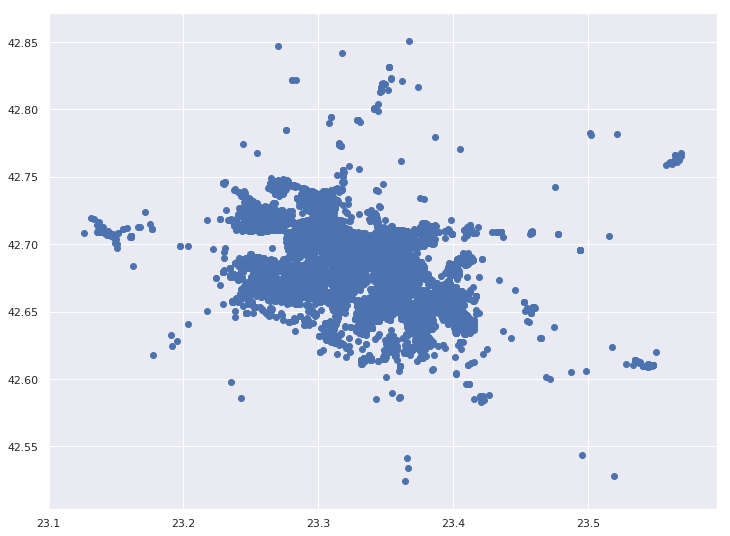